# Create all charts
---

## The data sets we used are:
* City of San Diego 311 service requests
* The San Diego zip codes from the US Census Bureau
* Economic census data for San Diego by zipcode from the US Census Bureau
* Open Weather Map History for temperature information

In [3]:
import os
import gmaps
import datetime
import numpy as np
import regex as reg
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress

pd.options.display.float_format = '{:,.2f}'.format

plt.style.use('fivethirtyeight')


In [4]:
path_311 = os.path.join('..', 'data', 'final_311.csv')
df = pd.read_csv(path_311)
df.dropna(inplace=True)

### Number of 311 calls by month

* calls from 2017-03-11 to 2018-03-10

In [5]:
period_311 = df[df['date'] > '2017-03-10']
period_311 = period_311[period_311['date'] < '2018-03-11']
months = period_311.groupby('month', as_index=False)['service_request_id'].count()
months['month'] = months['month'].map(lambda x: datetime.date(1900, int(x), 1).strftime('%B'))

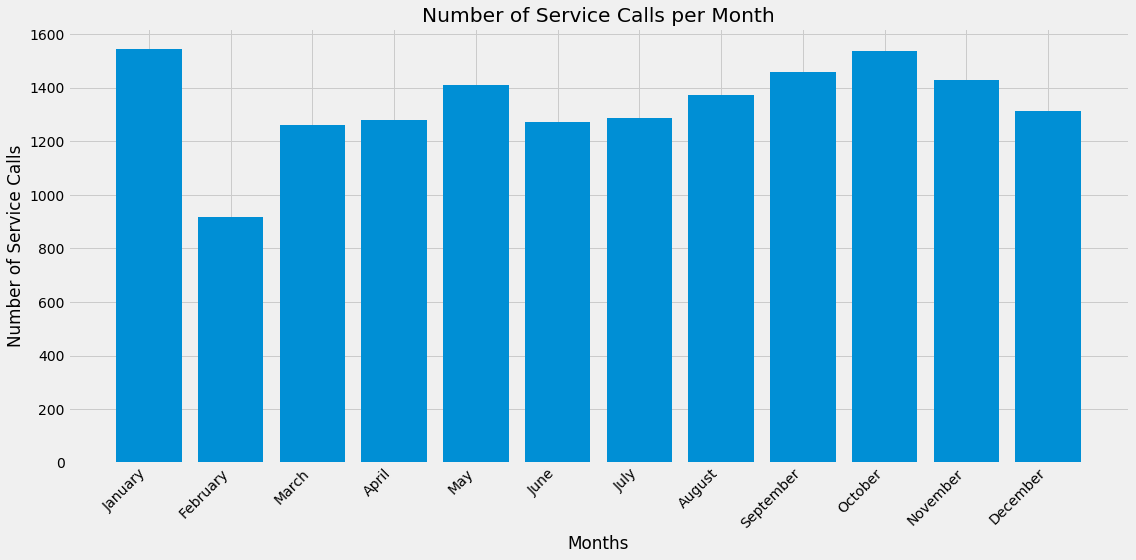

In [6]:
plt.figure(figsize=[16, 8])
plt.bar(months['month'], months['service_request_id'], align='center')
plt.title('Number of Service Calls per Month')
plt.xlabel('Months')
plt.ylabel('Number of Service Calls')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(os.path.join('..', 'figures', 'calls_per_month_bar.png'))

### Number of Calls by Weekday

In [7]:
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', ]
weekdays = df.groupby('weekday', as_index=False)['service_request_id'].count()
weekdays['day_order'] = weekdays['weekday'].map(lambda x: days.index(x))
weekdays.sort_values('day_order', inplace=True)

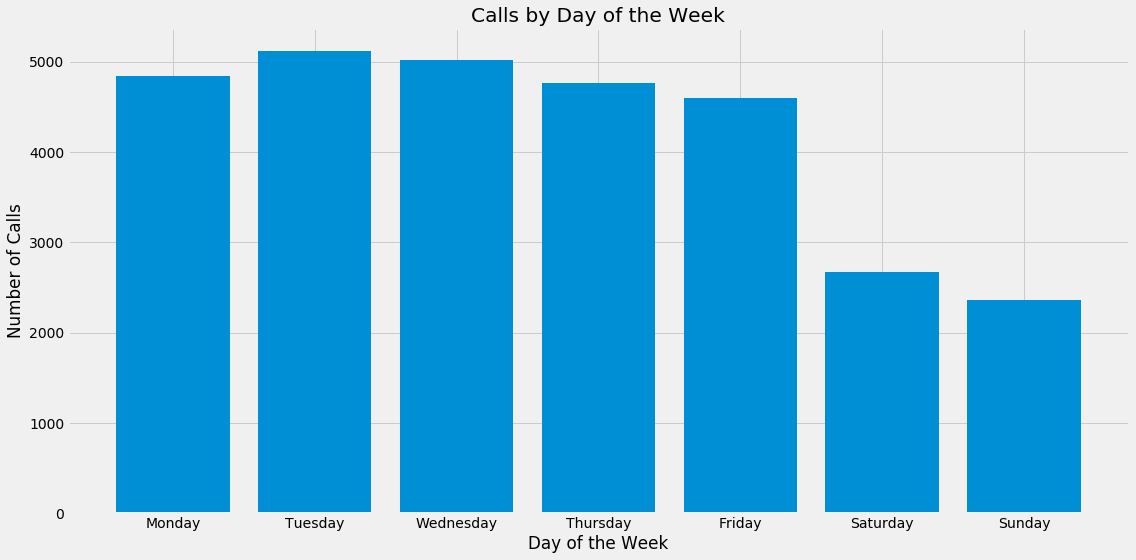

In [8]:
plt.figure(figsize=[16, 8])
plt.bar(weekdays['weekday'], weekdays['service_request_id'], align='center')
plt.title('Calls by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Calls')
plt.tight_layout()
plt.savefig(os.path.join('..', 'figures', 'calls_by_day_bar.png'))

## Number of 311 Call by Zip Code

In [9]:
zip_service = df.groupby('zip_code')['service_request_id'].count().sort_values(ascending=False)
service = zip_service[zip_service > 0]

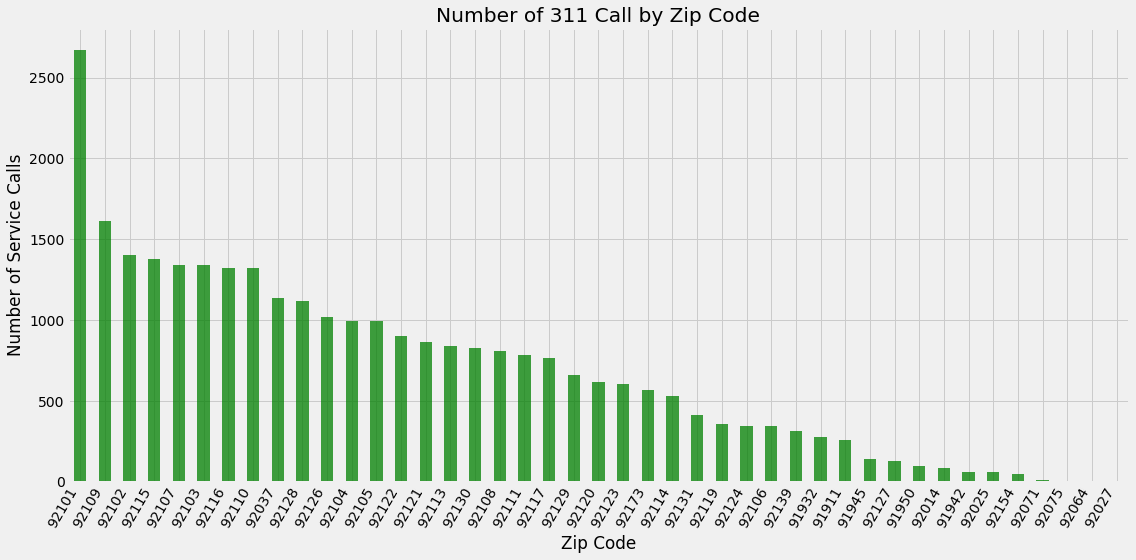

In [10]:
fig, ax = plt.subplots(figsize=[16, 8])
zip_service_plt = zip_service.plot(kind='bar', color='green',alpha =0.75)
plt.xlabel('Zip Code')
plt.ylabel('Number of Service Calls')
plt.title('Number of 311 Call by Zip Code')
plt.xticks(rotation=60, ha='right')
plt.tight_layout()
plt.savefig(os.path.join('..','figures','number_of_311_call_by_zip_code.png'))

### locations of callers Heatmap

In [11]:
coordinates= df.groupby('zip_code')[['lat','long']].mean().dropna()

In [13]:
from config import gkey
gmaps.configure(api_key=gkey)
heat_map = gmaps.heatmap_layer(coordinates,weights=service,point_radius=80,opacity=.5)
fig = gmaps.figure()
fig.add_layer(heat_map)
fig

Figure(layout=FigureLayout(height='420px'))

### Number of 311 calls by type

* Garrett is working on this

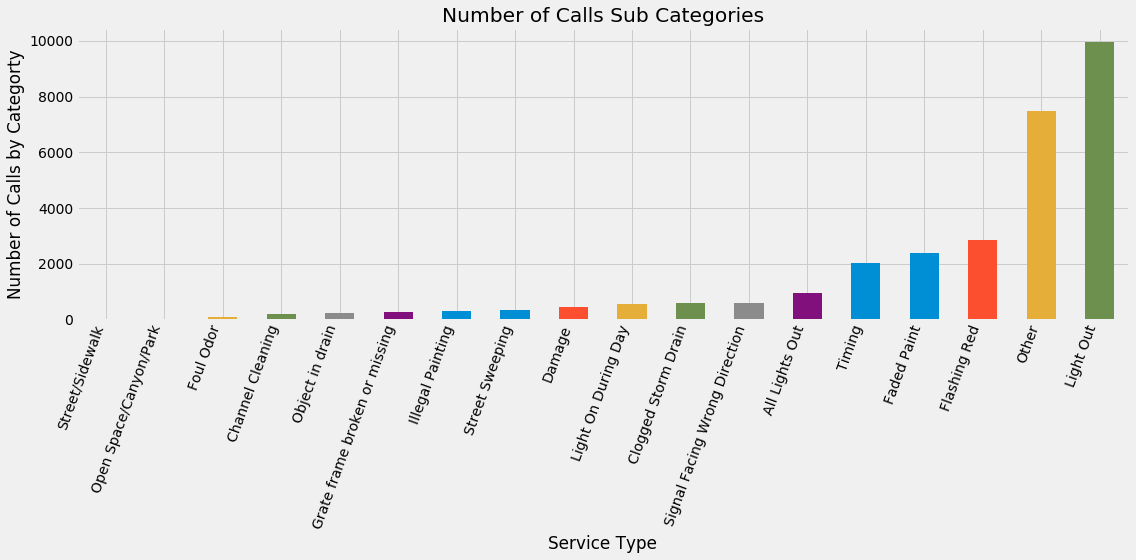

In [14]:
service = df.groupby('service_subtype')['service_request_id'].count().sort_values().tail(20)
fig, ax = plt.subplots(figsize=[16, 8])
service.plot.bar()
plt.title('Number of Calls Sub Categories')
plt.xlabel('Service Type')
plt.ylabel('Number of Calls by Categorty')
plt.xticks(rotation=70, ha='right')
plt.tight_layout()
plt.savefig(os.path.join('..','figures','number_of_311_call_by_category_bar.png'))

### Number of calls per capita by zipcode

In [15]:
pop_path = os.path.join('..', 'data', 'census_population_by_zip.csv')
pop_df = pd.read_csv(pop_path)

### Number of calls by median household income of zip

In [16]:
income_path = os.path.join('..', 'data', 'census_income_by_zip.csv')
income_df = pd.read_csv(income_path)

### Scatter

In [17]:
call_by_zip = zip_service.to_frame().sort_values('zip_code')
call_by_income = pd.merge(call_by_zip, income_df, how='left', on='zip_code')

In [18]:
call_by_income.head()

,zip_code,service_request_id,Mean income,MoE Mean income,Median income,MoE Median income
0,91911,256,62932,2137,51383,1874
1,91932,275,59870,2942,48010,1975
2,91942,62,70677,3837,55753,3194
3,91945,140,66936,2833,59025,3337
4,91950,100,54302,2179,41867,1768


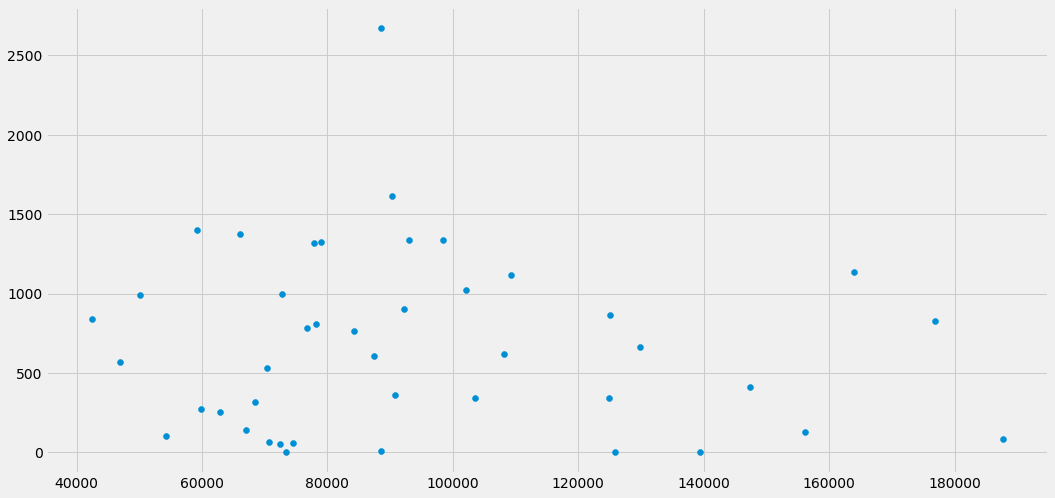

In [22]:
plt.figure(figsize=[16, 8])
plt.scatter(call_by_income['Mean income'], call_by_income['service_request_id'])

In [23]:
pop_income_df = pop_df.merge(income_df, on='zip_code', how='right')

In [24]:
zip_gp = df.groupby('zip_code', as_index=False)
med_income = zip_gp['Median income'].mean()
zip_calls = zip_gp['service_request_id'].count()
total_pop = zip_gp['total population'].first()

In [25]:
med_income['Median income'].describe()

count        43.00
mean     72,637.67
std      25,678.18
min      31,001.00
25%      56,001.50
50%      66,297.00
75%      87,640.50
max     136,855.00
Name: Median income, dtype: float64

In [26]:
calls_income = med_income.merge(zip_calls, on='zip_code', how='outer')
calls_income = calls_income.merge(total_pop, on='zip_code', how='outer')

In [27]:
bins = [0, 35000, 55000, 75000, 95000, 115000, 999999999]
bin_names = ['<$35,000', '\$35,001-\$55,000', '\$55,001-\$75,000', '\$75,001-\$95,000', '\$95,001-\$115,000', '>$115,000']
calls_income['income_ranges'] = pd.cut(x=calls_income['Median income'], bins=bins, labels=bin_names)
calls_income_gp = calls_income.groupby(by='income_ranges', as_index=False)
call_count = calls_income_gp['service_request_id'].sum()
total_pop_per_range = calls_income_gp['total population'].sum()
call_count['total population'] = total_pop_per_range['total population']
call_count['caller percentage'] = (call_count['service_request_id'] / call_count['total population']) * 100

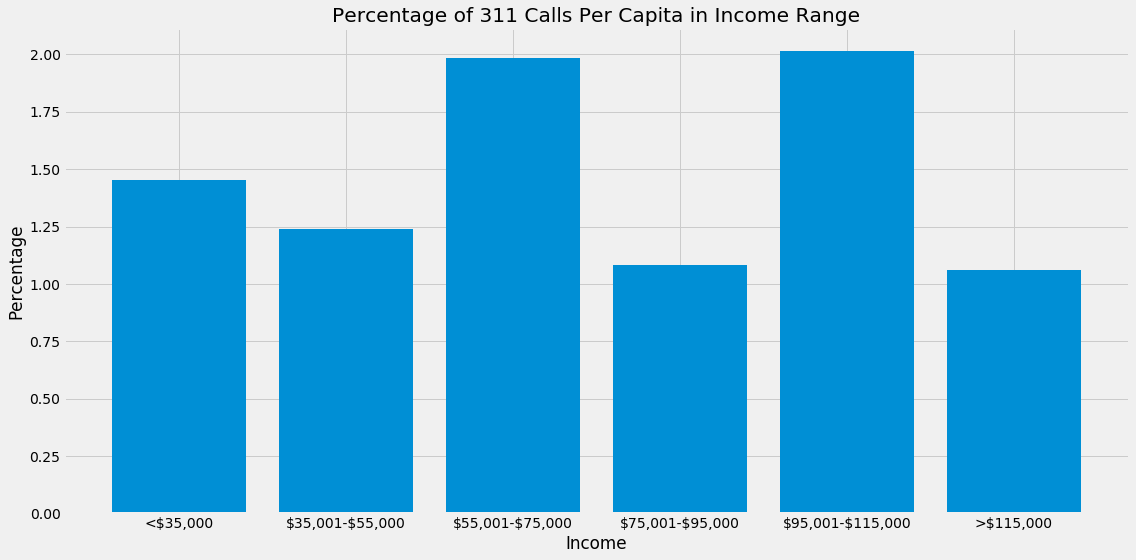

In [28]:
plt.figure(figsize=[16, 8])
plt.bar(call_count['income_ranges'], call_count['caller percentage'])
plt.xticks()
plt.title('Percentage of 311 Calls Per Capita in Income Range')
plt.xlabel('Income')
plt.ylabel('Percentage')
plt.tight_layout()
plt.savefig(os.path.join('..', 'figures', 'percentage_per_capita_income_bar.png'))

### Number of calls by Temperature scatter

* calls from 2017-03-11 to 2018-03-10

In [29]:
owm_path = os.path.join('..', 'data', 'owm_2016_2018.csv')
temp_df = pd.read_csv(owm_path)
temp_df['date'] = temp_df['dt_iso'].map(lambda x: reg.sub('\s\d{2}:\d{2}:\d{2}\s\+\d{4}\sUTC', '', x))
temp_df = temp_df[temp_df['date'] > '2017-03-10']
temp_df = temp_df[temp_df['date'] < '2018-03-11']
temp_df = temp_df.groupby('date', as_index=False).mean()

In [30]:
date_311 = period_311.groupby('date', as_index=False).count()

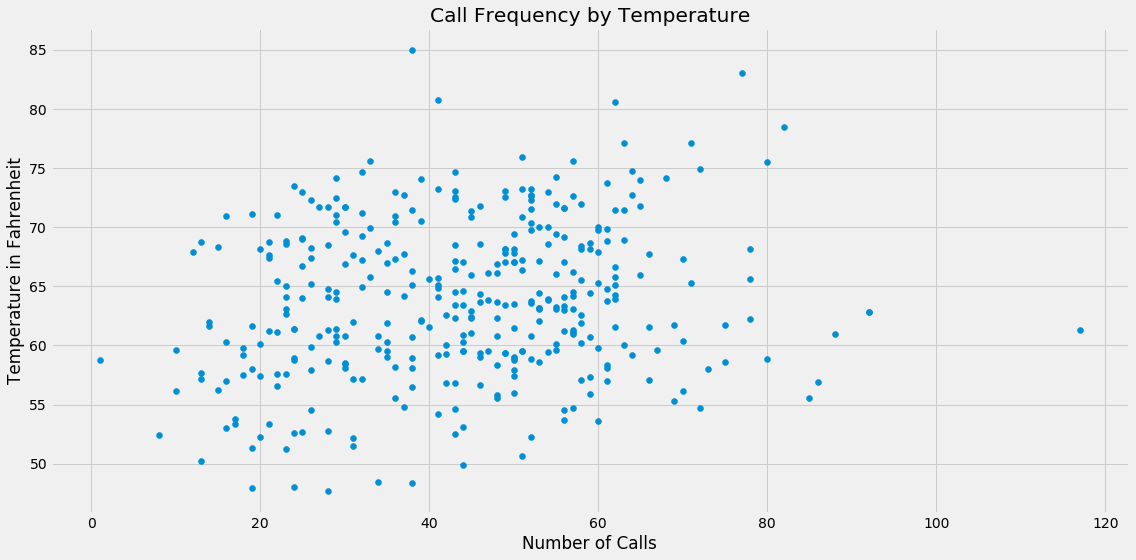

In [31]:
plt.figure(figsize=[16, 8])
plt.scatter(date_311['service_request_id'], temp_df['temp_f'])
plt.title('Call Frequency by Temperature')
plt.xlabel('Number of Calls')
plt.ylabel('Temperature in Fahrenheit')
plt.tight_layout()
plt.savefig(os.path.join('..', 'figures', 'calls_by_temp_scatter.png'))

In [32]:
zip_population = df.groupby('zip_code')['total population'].sum().sort_values(ascending=False)

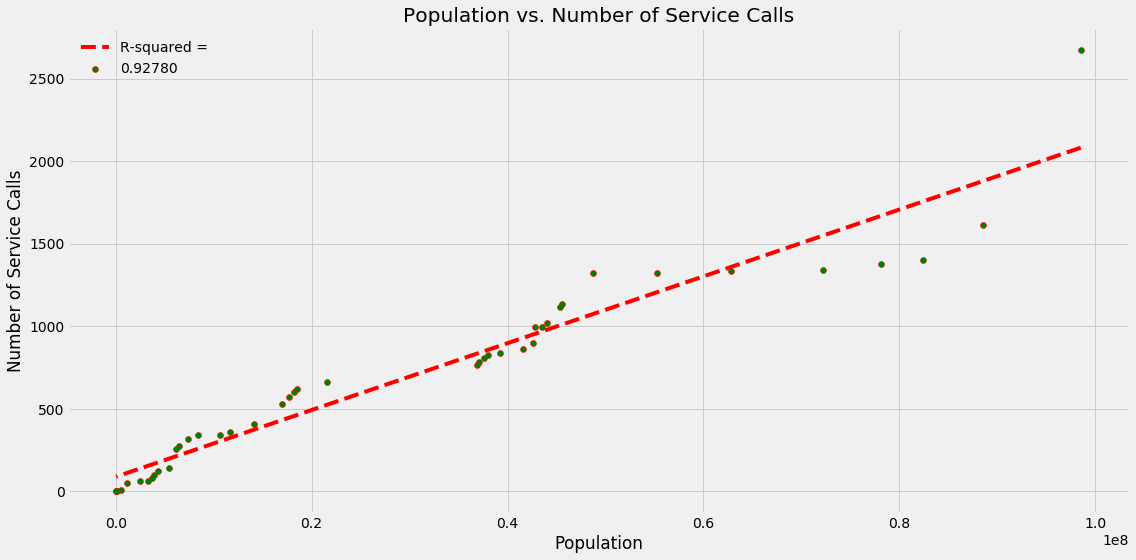

In [33]:
slope, intercept, r_value, p_value,_ = linregress(zip_population, zip_service)
fit = slope * zip_population + intercept
plt.figure(figsize=[16, 8])
plt.scatter(zip_population,zip_service,color='green', edgecolor='r')
plt.plot(zip_population, fit, color='red', linestyle='dashed')
plt.legend((f'R-squared = ','{0:.5f}'.format(r_value**2)),loc='upper left', frameon=False)
plt.xlabel("Population")
plt.ylabel("Number of Service Calls")
plt.title("Population vs. Number of Service Calls")
plt.tight_layout()
plt.savefig(os.path.join('..','figures','population_by_number of service request.png'))